In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 5

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_voting'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 775.72it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []


# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                
                
            else:
                val_score, val_loss = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/5:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 200/203 [00:17<00:00, 15.08img/s]

***
Unet Loss: 0.25406602025032043     Segnet Loss: 0.38442274928092957     Enet Loss: 0.5091997385025024
Voting Loss: 0.3825628360112508


Epoch 1/5:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 200/203 [00:20<00:00,  9.61img/s]


---
Unet Validation Dice Score: 0.30929142236709595     Segnet Validation Dice Score: 0.6447784304618835     Enet Validation Dice Score: 0.2561783790588379
Ensemble Voting Validation Dice Score: 0.5745090842247009 
Ensemble Voting Validation Dice Loss: 1.105337142944336


Epoch 2/5:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.29631781578063965     Segnet Loss: 0.3522384762763977     Enet Loss: 0.33497798442840576
Voting Loss: 0.327844758828481


Epoch 2/5:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 200/203 [00:18<00:00, 10.76img/s]


---
Unet Validation Dice Score: 0.7544906139373779     Segnet Validation Dice Score: 0.7005497813224792     Enet Validation Dice Score: 0.52192223072052
Ensemble Voting Validation Dice Score: 0.7259755730628967 
Ensemble Voting Validation Dice Loss: 0.8403350710868835


Epoch 3/5:  35%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 72/203 [00:06<00:09, 14.30img/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5d1825a4d0>
Traceback (most recent call last):
  File "/home/user1/anaconda3/envs/ksh/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/user1/anaconda3/envs/ksh/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/user1/anaconda3/envs/ksh/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/user1/anaconda3/envs/ksh/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait(

KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt

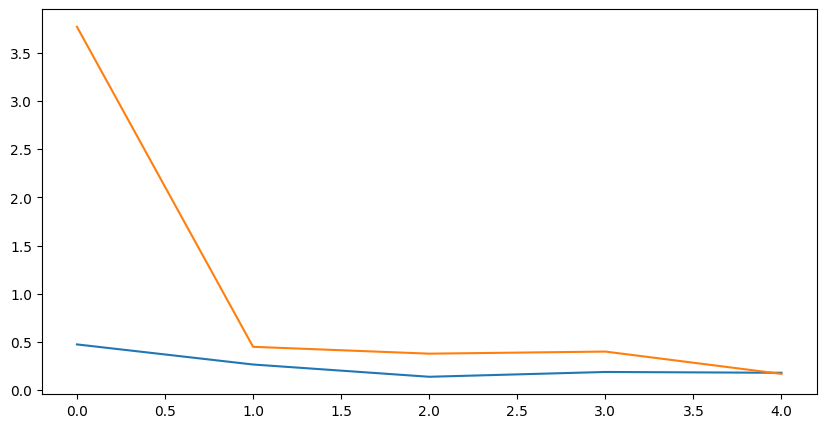

In [11]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

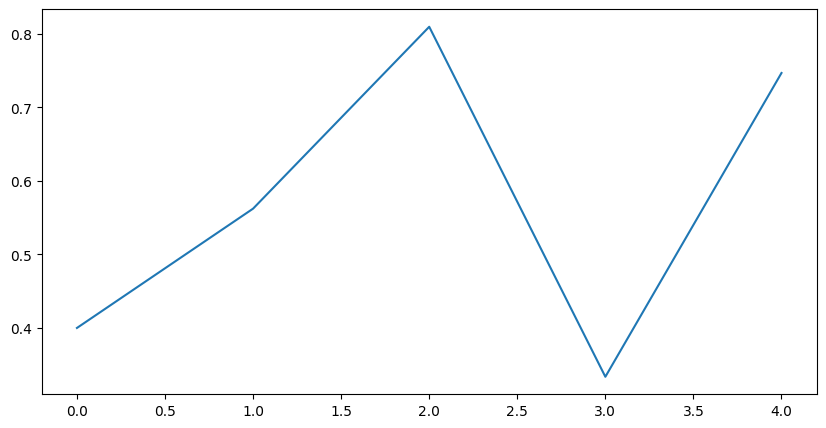

In [12]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)